# Generating Faces Using Generative Adversarial Networks


### Team Members : 
- Prateesh Reddy Patlolla (prpatlol)
- Yaswanth Karri (yaskarr)
- Shubham Kumar Singh (shusingh)
- Nrusimha Vihari Eyunni (neyunni)

In this project, we are defining a GAN on a dataset of faces. The goal is to get a generator network to generate new images of faces that look as realistic as possible!

This project will be broken down into a series of tasks from loading in data, normalise the data to defining and training adversarial networks and generate new faces. Our generated samples should look like fairly realistic faces with small amounts of noise.

## Get the Data

We'll be using the [Flickr-Faces-HQ Dataset (FFHQ)](https://archive.org/details/ffhq-dataset) to train your adversarial networks.

This dataset includes more variation than CELEBA-HQ dataset in terms of age, ethnicity and image background, and also has much better coverage of accessories such as eyeglasses, sunglasses, hats, etc. The images were crawled from [Flickr](https://www.flickr.com/) and then automatically aligned and cropped.

*The Training Data has been downloaded from this [website](https://archive.org/details/ffhq-dataset).
There is a download zip file that you'll need to extract in order to run this notebook.*


In [3]:
# Import Torch 
import torch
from torch import nn
from torch.nn import Parameter, functional as F
from torchvision import datasets
import torchvision.transforms as Tranf
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image
from PIL import Image
import torchvision.transforms as transforms
import torchvision.models as models
from tqdm.notebook import tqdm
from IPython.display import Image

# Library for Image Augmentation
import albumentations
import multiprocessing
import os

# Copy content from Source and Destination
import shutil
import cv2
import torch.nn as nn
import numpy as np

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sb

In [ ]:
path = ("../input")
image_paths = os.listdir("../input/flickrfaceshq-dataset-ffhq")
image_paths = [f"../input/flickrfaceshq-dataset-ffhq/{el}" for el in image_paths]
image_paths[:10]

['../input/flickrfaceshq-dataset-ffhq/27147.png',
 '../input/flickrfaceshq-dataset-ffhq/52235.png',
 '../input/flickrfaceshq-dataset-ffhq/32352.png',
 '../input/flickrfaceshq-dataset-ffhq/41695.png',
 '../input/flickrfaceshq-dataset-ffhq/21130.png',
 '../input/flickrfaceshq-dataset-ffhq/36145.png',
 '../input/flickrfaceshq-dataset-ffhq/22897.png',
 '../input/flickrfaceshq-dataset-ffhq/18966.png',
 '../input/flickrfaceshq-dataset-ffhq/22069.png',
 '../input/flickrfaceshq-dataset-ffhq/47434.png']

## Data Preprocessing

- One huge benifit of using Flickr-Faces-HQ Dataset is that each of the image has been cropped to remove parts of the image that don't include a face using [dlib](http://dlib.net/). 
- We then resize this down to 3x64x64 NumPy images. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces. 
- The 3 is for RGB channels and then visualize our train data.

#### ImageFolder
To create a dataset given a directory of images, We use PyTorch's ImageFolder wrapper, with a root directory - /input/flickrfaceshq-dataset-ffhq/ and data transformation passed in.

- Image size is resized to 64. 

We will be using :
- **batch_size:** The number of Images in each batch
- **size_of_image:** Square size of the image

In [ ]:
size_of_image = 64
batch_size = 128
stats = (0.5, 0.5, 0.5),(0.5, 0.5, 0.5)

#### DataLoader

we change the image size to 64 and reasonable batch_size parameter is 128. After loading our normalised data we are all set to visualize some images!

In [ ]:
# Image Augmentaion
aug_image = Tranf.Compose([Tranf.Resize(size_of_image),
                           Tranf.CenterCrop(size_of_image),
                           Tranf.ToTensor(),
                           Tranf.Normalize(*stats)])

image_dataset = datasets.ImageFolder( path , transform = aug_image)

# Data Loader
train_loader = DataLoader(image_dataset,
                      batch_size=batch_size,
                      shuffle = True,
                      pin_memory = True,
                      num_workers = 3)

In [ ]:
def display_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    # Denorm images
    tensr_imgs = (images.detach()[:nmax]) * stats[0][1] + stats[0][0]
    ax.imshow(make_grid(tensr_imgs, nrow=8).permute(1, 2, 0))

### Viewing Images

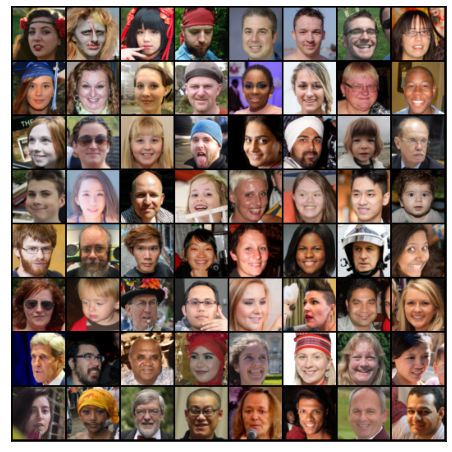

In [ ]:
for images,_ in train_loader:
        display_images(images)
        break

### Check for Availability of GPU

Checking if we have available GPU. if it is available , it will used to train.

We move Models, Model inputs, and Loss function arguments into GPU whenever needed by using <mark>tensor.to(device)</mark> in our function

In [ ]:
if torch.cuda.is_available:
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(itr, device) for itr in data]
    else:
        return data.to(device, non_blocking = True)
    
class device_loader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device    
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)        
    def __len__(self):
        return len(self.dl)             

In [ ]:
# Train Loader 
train_loader = device_loader(train_loader, device)

## Define the Model
A GAN is comprised of two adversarial networks:
 - Discriminator 
 - Generator 

<img src= "files/flow.png">

### Discriminator

We are using deep network with normalization to deal with this complex data.This works in the same way as a convolutional classifier, but without the maxpooling layers.

The inputs to the discriminator are 3x64x64 tensor images
The output should be a single value that will indicate whether a given image is real or fake

- We are using Leaky ReLU as it allows a small slope for negative values instead of a flat slope.As a result, the discriminator's gradients flow stronger through the generator.In the back-prop pass, instead of passing a 0 gradient (slope), it passes a slight negative gradient.

In [ ]:
discriminator = nn.Sequential(

    #initial dim : 3 x 64 x 64
    nn.Conv2d(3, 64,kernel_size = 4,stride = 2,padding = 1,bias = False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace = True),
    
    #dim : 64 x 32 x 32
    nn.Conv2d(64, 128,kernel_size = 4,stride = 2,padding = 1,bias = False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace = True),
    
    #dim : 128 x 16 x 16
    nn.Conv2d(128, 256,kernel_size = 4,stride = 2, padding = 1,bias = False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace = True),
    
    #dim : 256 x 8 x 8
    nn.Conv2d(256, 512,kernel_size = 4,stride = 2,padding = 1,bias = False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace = True),
    
    #dim : 512 x 4 x 4
    nn.Conv2d(512, 1,kernel_size = 4,stride = 1,padding = 0,bias = False),
    #dim : 1 x 1 x 1
    nn.Flatten(),
    nn.Sigmoid()
    
)

In [ ]:
discriminator = to_device(discriminator, device)

### Generator

- The Generator learns to create fake data by incorporating input from the Discriminator
- The generator should upsample an input and generate a new image of the same size as our training data. This should be mostly transpose convolutional layers with normalization applied to the outputs.The inputs to the generator are vectors of some length.
- The latent tensor of form 128 x 1 x 1 will be converted into an image tensor of shape 3 x 28 x 28 by the generator.
- With the exception of the output layer, which uses the Tanh function as the activation function, the generator uses the ReLU activation along with Batch Normalization.

In [ ]:
# Size of Latent
lat_size = 128
generator = nn.Sequential(
    
    # Convolutional Transpose
    nn.ConvTranspose2d(lat_size,512,kernel_size = 4,stride = 1,padding = 0,bias = False),
    # Batch Norm
    nn.BatchNorm2d(512),
    # RELU 
    nn.ReLU(True),
    
    # Convolutional Transpose
    nn.ConvTranspose2d(512, 256,kernel_size = 4,stride = 2,padding = 1,bias = False),
    # Batch Norm
    nn.BatchNorm2d(256),
    # RELU 
    nn.ReLU(True),

    # Convolutional Transpose
    nn.ConvTranspose2d(256, 128,kernel_size = 4,stride = 2,padding = 1,bias = False),
    # Batch Norm
    nn.BatchNorm2d(128),
    # RELU 
    nn.ReLU(True),
    
    # Convolutional Transpose
    nn.ConvTranspose2d(128, 64,kernel_size = 4,stride = 2,padding = 1,bias = False),
    # Batch Norm
    nn.BatchNorm2d(64),
    # RELU 
    nn.ReLU(True),
    
    # Convolutional Transpose
    nn.ConvTranspose2d(64, 3,kernel_size = 4,stride = 2,padding = 1,bias = False),
    nn.Tanh()
    
)

torch.Size([128, 3, 64, 64])


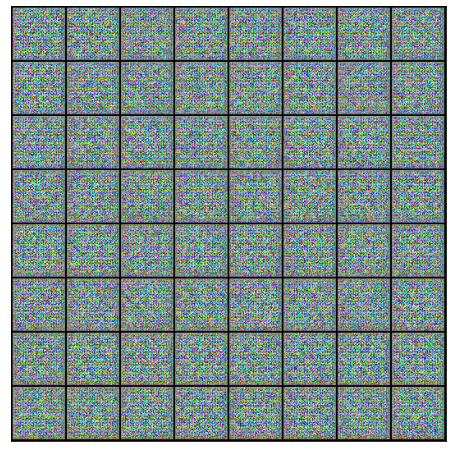

In [ ]:
xb = torch.randn(batch_size, lat_size, 1, 1)
fake_imgs = generator(xb)
# Shape of Image
print(fake_imgs.shape)
# Displaying Fake images
display_images(fake_imgs)

In [ ]:
# Generator
generator = to_device(generator, device)

## Training Discriminator 

The discriminator will return :
 - **1:**  if the image was taken from real dataset
 - **0:** if the image was created using the generator

Setting the gradients to zero by using **zero_grad( )** before starting to do backpropragation so that the parameter update is done correctly. 

We are using Binary Cross entropy Loss fucntion for recognizing the difference between real and fake images

The loss is determined after a batch of real images is given to the discriminator, with target labels for the images(real) being 1.The discriminator is then given a batch of fake images (generated by the generator) and the loss is calculated with the target labels for the fake images being 0.The two losses are combined together, and the weights are adjusted based on the total loss.


In [ ]:
def train_discriminator(real_imgs, optim):
    
    optim.zero_grad()
    
    pred_real = discriminator(real_imgs)
    tar_real = torch.ones(real_imgs.size(0), 1, device = device)
    loss_real = F.binary_cross_entropy(pred_real, tar_real)
    score_real = torch.mean(pred_real).item()
    
    latent = torch.randn(batch_size, lat_size, 1, 1, device = device)
    fake_imgs = generator(latent)
    
    pred_fake = discriminator(fake_imgs)
    tar_fake = torch.zeros(fake_imgs.size(0), 1, device = device)
    loss_fake = F.binary_cross_entropy(pred_fake, tar_fake)
    score_fake = torch.mean(pred_fake).item()
    
    loss = loss_real + loss_fake
    loss.backward()
    optim.step()
    
    return loss.item(), score_real, score_fake

## Training Generator

Generator is expected to generate an image that can fool discriminator about the image being real or fake(generated).

- A batch of images are generated using the generator and passed into the discriminator.
- Loss is calculated by setting the target labels to 1 i.e. real.
- This is done because the generator’s objective is to fool the discriminator.

This loss is used to change the weights of the generator, so it gets better at generating real-like images to fool the discriminator better.

In [ ]:
def train_generator(optim):
    
    optim.zero_grad()
    
    lat = torch.randn(batch_size, lat_size, 1, 1, device = device)
    fake_imgs = generator(lat)
    
    pred_fake = discriminator(fake_imgs)
    targets = torch.ones(fake_imgs.size(0), 1, device = device)
    loss = F.binary_cross_entropy(pred_fake, targets)
    
    loss.backward()
    optim.step()
    
    return loss.item()

In [ ]:
dir_s = 'generated'
os.makedirs(dir_s, exist_ok=True)

def store_samples(idx, lat_tensors, bool_disp = True):
    fake_imgs = generator(lat_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(idx)
    tensr_imgs = (fake_imgs) * stats[0][1] + stats[0][0]
    save_image(tensr_imgs, os.path.join(dir_s, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if bool_disp:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_imgs.cpu().detach(), nrow=8).permute(1, 2, 0))

Saving generated-images-0000.png


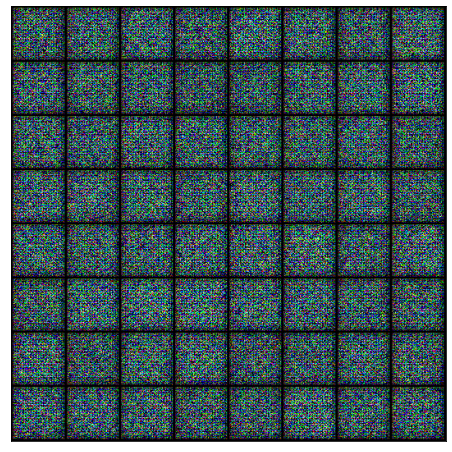

In [ ]:
latent_fxd = torch.randn(64, lat_size, 1, 1, device=device)
store_samples(0, latent_fxd)

## Training

Generator progresses with training and the performance of the discriminator gets worse as it cant differentiate between real and fake.So we are improving the performance of the discriminator along with generator.

Training is the most difficult aspect and since a GAN consists of two independently trained networks.

In [ ]:
def fit(n_epochs, learning_rate, idx_begin = 1):
    
    torch.cuda.empty_cache()
    
    gen_loss,disc_loss,scores_real,scores_fake  = [],[],[],[]

    optim_disc = torch.optim.Adam(discriminator.parameters(),
                                  lr = learning_rate,
                                  betas = (0.5, 0.999)) 
    optim_gen = torch.optim.Adam(generator.parameters(),
                                 lr = learning_rate,
                                 betas = (0.5, 0.999)) 
    
    for epoch in range(n_epochs):
        
        for real_imgs,_ in tqdm(train_loader):
            
            loss_disc, score_real, score_fake = train_discriminator(real_imgs, optim_disc)
            
            loss_gen = train_generator(optim_gen)
            
        gen_loss.append(loss_gen)
        disc_loss.append(loss_disc)
        scores_real.append(score_real)
        scores_fake.append(score_fake)

        print("Epoch [{}/{}], Loss_gen: {:.4f}, Loss_disc: {:.4f}, Score_real: {:.4f}, Score_fake: {:.4f}".format(
        epoch+1, n_epochs, loss_gen, loss_disc, score_real, score_fake))

        store_samples(epoch+idx_begin, latent_fxd, bool_disp=False)
        
    return gen_loss, disc_loss, scores_real, scores_fake

In [ ]:
!nvidia-smi

Sat Apr 24 14:33:00 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    35W / 250W |   1075MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
learning_rate = 0.0002
n_epochs = 25
gen_loss, disc_loss, scores_real, scores_fake = fit(n_epochs, learning_rate)

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [1/25], loss_g: 4.4531, loss_d: 0.3823, real_score: 0.7548, fake_score: 0.0439
Saving generated-images-0001.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [2/25], loss_g: 7.3169, loss_d: 1.0208, real_score: 0.8865, fake_score: 0.5212
Saving generated-images-0002.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [3/25], loss_g: 4.9899, loss_d: 0.6132, real_score: 0.9353, fake_score: 0.3746
Saving generated-images-0003.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [4/25], loss_g: 5.0963, loss_d: 0.6180, real_score: 0.8877, fake_score: 0.3489
Saving generated-images-0004.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [5/25], loss_g: 3.2044, loss_d: 0.3336, real_score: 0.8713, fake_score: 0.1478
Saving generated-images-0005.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [6/25], loss_g: 1.6824, loss_d: 0.4970, real_score: 0.6632, fake_score: 0.0256
Saving generated-images-0006.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [7/25], loss_g: 1.0139, loss_d: 0.7535, real_score: 0.5364, fake_score: 0.0111
Saving generated-images-0007.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [8/25], loss_g: 4.5706, loss_d: 0.2680, real_score: 0.9122, fake_score: 0.1363
Saving generated-images-0008.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [9/25], loss_g: 2.5590, loss_d: 0.3024, real_score: 0.8613, fake_score: 0.1227
Saving generated-images-0009.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [10/25], loss_g: 4.4051, loss_d: 0.4028, real_score: 0.9927, fake_score: 0.2878
Saving generated-images-0010.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [11/25], loss_g: 5.2564, loss_d: 0.2276, real_score: 0.9838, fake_score: 0.1748
Saving generated-images-0011.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [12/25], loss_g: 0.5913, loss_d: 0.9999, real_score: 0.4403, fake_score: 0.0067
Saving generated-images-0012.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [13/25], loss_g: 3.1179, loss_d: 0.3922, real_score: 0.7843, fake_score: 0.0917
Saving generated-images-0013.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [14/25], loss_g: 1.1611, loss_d: 0.4922, real_score: 0.6879, fake_score: 0.0611
Saving generated-images-0014.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [15/25], loss_g: 2.7981, loss_d: 0.2458, real_score: 0.8568, fake_score: 0.0736
Saving generated-images-0015.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [16/25], loss_g: 4.8835, loss_d: 0.3543, real_score: 0.9127, fake_score: 0.2018
Saving generated-images-0016.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [17/25], loss_g: 2.1735, loss_d: 0.2353, real_score: 0.8963, fake_score: 0.1030
Saving generated-images-0017.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [18/25], loss_g: 0.9453, loss_d: 1.6688, real_score: 0.2811, fake_score: 0.0007
Saving generated-images-0018.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [19/25], loss_g: 0.9704, loss_d: 0.5399, real_score: 0.6759, fake_score: 0.0483
Saving generated-images-0019.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [20/25], loss_g: 3.4478, loss_d: 0.1319, real_score: 0.9752, fake_score: 0.0963
Saving generated-images-0020.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [21/25], loss_g: 5.8828, loss_d: 0.8211, real_score: 0.9080, fake_score: 0.4308
Saving generated-images-0021.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [22/25], loss_g: 3.1856, loss_d: 0.1044, real_score: 0.9371, fake_score: 0.0306
Saving generated-images-0022.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [23/25], loss_g: 4.4676, loss_d: 0.0955, real_score: 0.9483, fake_score: 0.0394
Saving generated-images-0023.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [24/25], loss_g: 1.5339, loss_d: 0.2306, real_score: 0.8536, fake_score: 0.0514
Saving generated-images-0024.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [25/25], loss_g: 2.7309, loss_d: 0.1374, real_score: 0.9131, fake_score: 0.0415
Saving generated-images-0025.png


In [ ]:
torch.save(generator.state_dict(), 'G.ckpt')
torch.save(discriminator.state_dict(), 'D.ckpt')

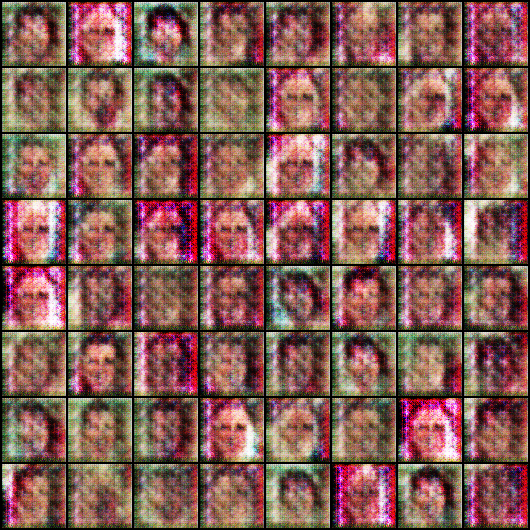

In [ ]:
Image('./generated/generated-images-0001.png')

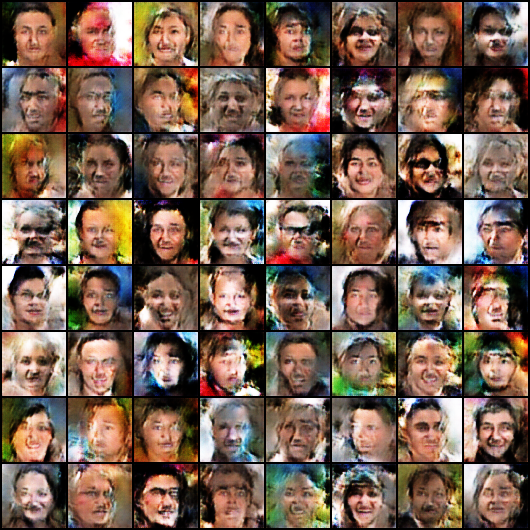

In [ ]:
Image('./generated/generated-images-0005.png')

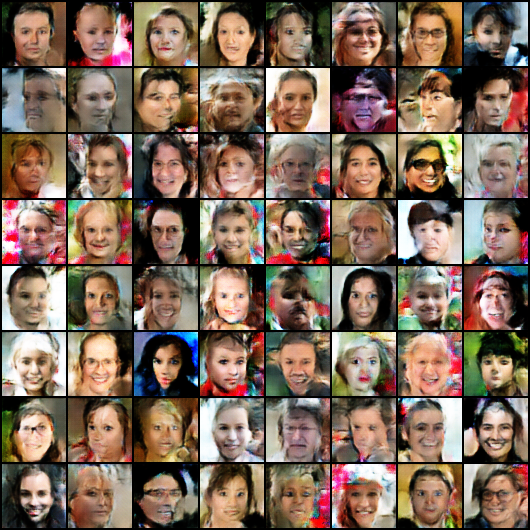

In [ ]:
Image('./generated/generated-images-0010.png')

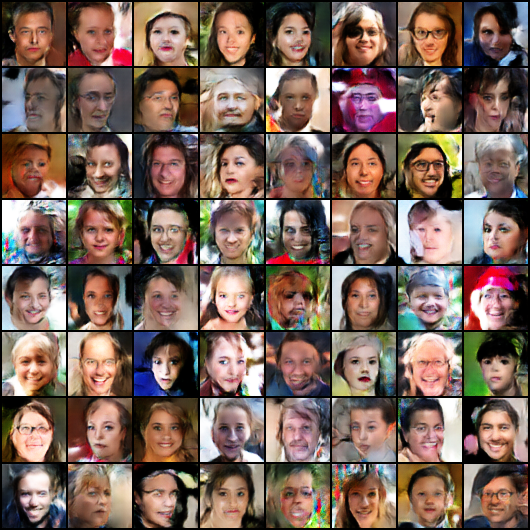

In [ ]:
Image('./generated/generated-images-0020.png')

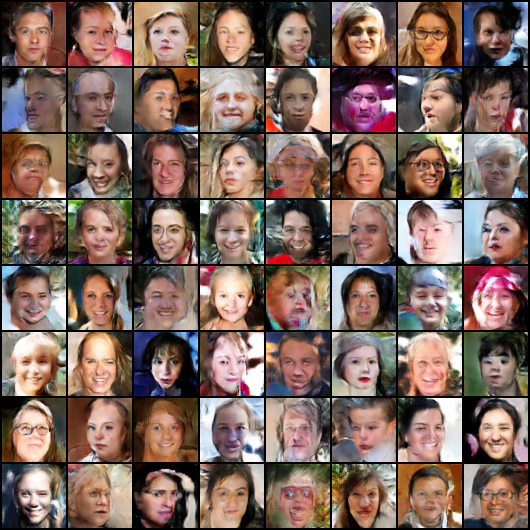

In [ ]:
Image('./generated/generated-images-0025.png')

In [ ]:
vid_fname = 'human_face_generator.avi'

files = [os.path.join(dir_s, f) for f in os.listdir(dir_s) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

### Generating Realistic Faces from random noise

<img src="files/human_face_generator.gif" >

## Evaluation

Plotting the Loss vs Epochs below wehre we can see that there genrator loss is reducing and the discriminator loss is not getting very high which is expected in GAN's.

Plots represented below for evaluation:

- Loss vs Epochs for Discriminator and Generator

- The Real and Fake Scores 


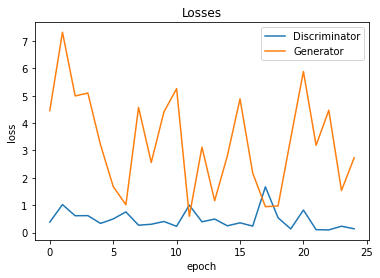

In [ ]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

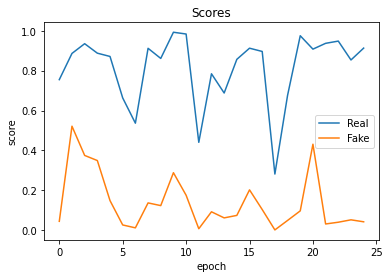

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.utils import save_image

In [8]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()

        self.chosen_features = ["0", "5", "10", "19", "28"]

        self.model = models.vgg19(pretrained=True).features[:29]

    def forward(self, x):
        # Store relevant features
        features = []

        for layer_num, layer in enumerate(self.model):
            # print(x.shape)
            x = layer(x)

            if str(layer_num) in self.chosen_features:
                features.append(x)

        return features


def load_image(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
imsize = 356

loader = transforms.Compose(
    [
        transforms.Resize((imsize, imsize)),
        transforms.ToTensor(),
    ]
)

original_img = load_image("GAN_output.png")
style_img = load_image("style.jpg")

generated = original_img.clone().requires_grad_(True)
model = VGG().to(device).eval()

# Hyperparameters
total_steps = 6000
learning_rate = 0.001
alpha = 1
beta = 0.01
optimizer = optim.Adam([generated], lr=learning_rate)

for step in range(total_steps):

    generated_features = model(generated)
    original_img_features = model(original_img)
    style_features = model(style_img)

    style_loss = original_loss = 0
    
    for gen_feature, orig_feature, style_feature in zip(
        generated_features, original_img_features, style_features
    ):

        # batch_size will just be 1
        batch_size, channel, height, width = gen_feature.shape
        original_loss += torch.mean((gen_feature - orig_feature) ** 2)
        # Compute Gram Matrix of generated
        G = gen_feature.view(channel, height * width).mm(
            gen_feature.view(channel, height * width).t()
        )
        # Compute Gram Matrix of Style
        A = style_feature.view(channel, height * width).mm(
            style_feature.view(channel, height * width).t()
        )
        style_loss += torch.mean((G - A) ** 2)

    total_loss = alpha * original_loss + beta * style_loss
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if step % 200 == 0:
        print(total_loss)
        save_image(generated, "generated.png")

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth



tensor(4066455.2500, device='cuda:0', grad_fn=<AddBackward0>)
tensor(209438.2188, device='cuda:0', grad_fn=<AddBackward0>)
tensor(118737.8359, device='cuda:0', grad_fn=<AddBackward0>)
tensor(78659.1484, device='cuda:0', grad_fn=<AddBackward0>)
tensor(56450.6094, device='cuda:0', grad_fn=<AddBackward0>)
tensor(43263.8906, device='cuda:0', grad_fn=<AddBackward0>)
tensor(34909.3945, device='cuda:0', grad_fn=<AddBackward0>)
tensor(29234.9219, device='cuda:0', grad_fn=<AddBackward0>)
tensor(25130.5176, device='cuda:0', grad_fn=<AddBackward0>)
tensor(22010.1816, device='cuda:0', grad_fn=<AddBackward0>)
tensor(19541.3633, device='cuda:0', grad_fn=<AddBackward0>)
tensor(17521.8457, device='cuda:0', grad_fn=<AddBackward0>)
tensor(15831.8379, device='cuda:0', grad_fn=<AddBackward0>)
tensor(14397.5654, device='cuda:0', grad_fn=<AddBackward0>)
tensor(13164.7451, device='cuda:0', grad_fn=<AddBackward0>)
tensor(12083.2100, device='cuda:0', grad_fn=<AddBackward0>)
tensor(11138.2871, device='cuda:0',

Displaying the Saved Genreated image

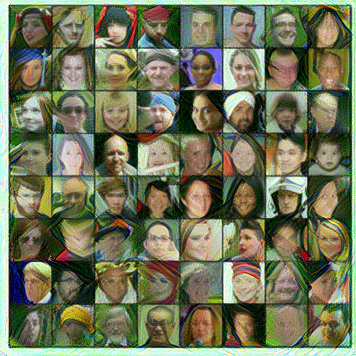

## References:

1: https://arxiv.org/abs/1511.06434

2: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

3: https://arxiv.org/abs/1406.2661 

4: https://stats.stackexchange.com/questions/242907/why-use-binary-cross-entropy-for-generator-in-adversarial-networks

5: https://machinelearningmastery.com/how-to-code-the-generative-adversarial-network-training-algorithm-and-loss-functions/
